In [203]:
import os
import sys
import numpy as np
from typing import Optional, Union, List
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import remove_unused_wires, get_control_channel_map, get_solver_and_freq_from_backend
from quantumenvironment import QuantumEnvironment

import jax
jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

In [204]:
from qiskit import pulse, transpile, schedule
from qiskit_dynamics.backend.dynamics_backend import _get_backend_channel_freqs, DynamicsBackend
from qiskit.circuit import QuantumCircuit, QuantumRegister, ParameterVector, Gate
from qiskit.circuit.library.standard_gates import ECRGate, SXGate
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit_experiments.calibration_management import Calibrations, FixedFrequencyTransmon, EchoedCrossResonance
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia, FakeJakarta, FakeJakartaV2, FakeHanoi, FakeCairo, FakeCambridge
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXStandard
from qiskit_ibm_runtime.options import Options, ExecutionOptions, EnvironmentOptions
from qconfig import QiskitConfig

Backend basis gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


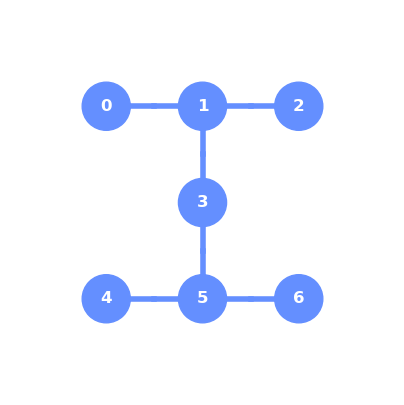

In [205]:
fake_backend = FakeJakarta() # FakeHanoi() # FakeJakarta() # mimics the bahaviour of a 7-qubits hardware
fake_backend_v2 = FakeJakartaV2()
print('Backend basis gates:', fake_backend.configuration().basis_gates)
plot_gate_map(fake_backend)

In [184]:
def get_sx_params(backend, physical_qubits):
    """
    Retrieve parameters for an SX gate from a quantum backend.

    This function retrieves the default parameters for an SX gate, including amplitude, beta, sigma, and duration,
    from a given quantum backend.

    Parameters:
    - backend (Backend): The quantum backend from which to retrieve the parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    
    Returns:
    - default_params (dict): A dictionary containing default parameters for the SX gate.
    - basis_gate_instructions (InstructionSchedule): The instruction schedule for the SX gate.
    - instructions_array (numpy.ndarray): An array of instructions for the SX gate.
    """


    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()

    basis_gate_instructions = instruction_schedule_map.get('sx', qubits=physical_qubits)
    
    instructions_array = np.array(basis_gate_instructions.instructions)[:,1]

    sx_pulse = basis_gate_instructions.instructions[0][1].pulse 

    default_params = {
        ("amp", physical_qubits, "sx"): sx_pulse.amp,
        # ("angle", physical_qubits, "sx"): sx_pulse.angle,
        ("β", physical_qubits, 'sx'): sx_pulse.beta,
        ("σ", physical_qubits, "sx"): sx_pulse.sigma,
        ("duration", physical_qubits, "sx"): sx_pulse.duration
    }

    return default_params, basis_gate_instructions, instructions_array

In [185]:
def custom_sx_schedule(backend: Backend, physical_qubits=Union[int, tuple, list], params: ParameterVector=None):
    """
    Generate a custom parameterized schedule for an SX gate.

    This function generates a custom parameterized schedule for an SX gate on specified physical qubits
    with the given parameters.

    Parameters:
    - backend (Backend): The quantum backend used to obtain default SX gate parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the SX gate.

    Returns:
    - parametrized_schedule (Schedule): A parameterized schedule for the SX gate with custom parameters.
    """
    
    # pulse_features = ["amp", "angle", "β", "σ"]
    pulse_features = ["amp", "β", "σ"]
 
    global n_actions
    assert n_actions == len(params), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})" 

    if isinstance(physical_qubits, int):
        physical_qubits = tuple(physical_qubits)

    new_params, _, _ = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

    for i, feature in enumerate(pulse_features):
        new_params[(feature, physical_qubits, "sx")] += params[i]

    cals = Calibrations.from_backend(backend, [FixedFrequencyTransmon(["x", "sx"])],
                                        add_parameter_defaults=True)
    
    parametrized_schedule = cals.get_schedule("sx", physical_qubits, assign_params=new_params)

    return parametrized_schedule

In [186]:
def add_parametrized_circuit(qc: QuantumCircuit, params: Optional[ParameterVector]=None, tgt_register: Optional[QuantumRegister]=None):
    """
    Add a parametrized gate to a QuantumCircuit.

    This function adds a parametrized gate to a given QuantumCircuit with optional custom parameters and target register.

    Parameters:
    - qc (QuantumCircuit): The QuantumCircuit to which the parametrized gate will be added.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the gate.
    - tgt_register (QuantumRegister, optional): The target quantum register for applying the parametrized gate.
    """
    
    global n_actions, fake_backend, target

    gate, physical_qubits = target["gate"], target["register"]
    physical_qubits = tuple(physical_qubits)

    if params is None:
        params = ParameterVector('theta', n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]

    parametrized_gate = gate.copy()
    parametrized_gate.params = params.params
    parametrized_schedule = custom_sx_schedule(backend=fake_backend, physical_qubits=physical_qubits, params=params)
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

# Example of a target gate: RX($\pi/2$) = $\sqrt{X}$

In [187]:
# SX gate as the target gat
sx_gate = {"gate": SXGate(), "register": [0]}
target = sx_gate
print(target)

{'gate': Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


##### Quantum Circuit context

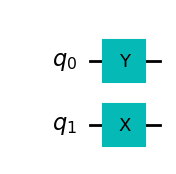

In [188]:
target_circuit = QuantumCircuit(2)
target_circuit.y(0)
# target_circuit.cx(0,1)
target_circuit.x([1])
target_circuit.draw("mpl")

Transpile the (context) quantum circuit to the provided (Fake-) Backend

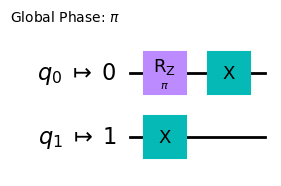

In [189]:
transpiled_circ = transpile(target_circuit, fake_backend, 
                              initial_layout=[0, 1],
                              basis_gates=fake_backend.configuration().basis_gates, 
                              optimization_level=1)

remove_unused_wires(transpiled_circ).draw("mpl")

Visualization of the "context" quantum circuit as a pulse sequence that the parametrized SX gate will then be added to

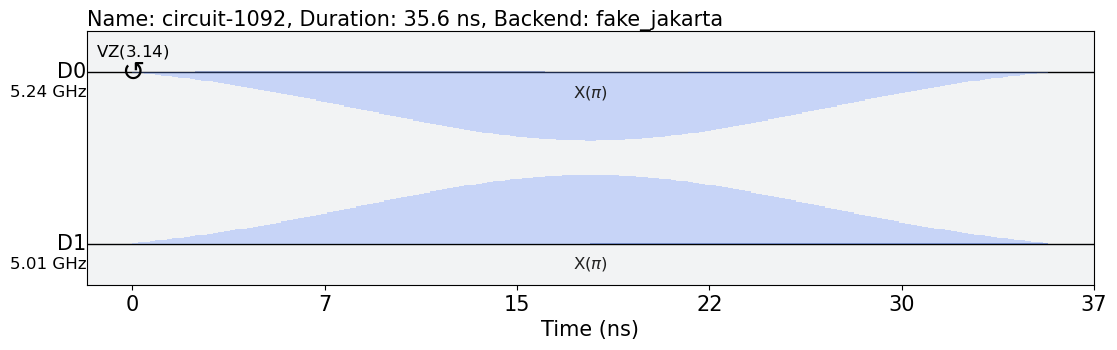

In [190]:
# schedule = build_schedule(transpiled_circ, fake_backend)
sched01 = schedule(transpiled_circ, fake_backend)
sched01.draw(backend=fake_backend, style=IQXStandard())

In [191]:
n_actions = 3 # number of parameters for the SX gate : amplitude and angle
print('Target gate:', target)

params = ParameterVector('theta', n_actions)

qubit = target["register"]
physical_qubits = tuple(qubit)

Target gate: {'gate': Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


Add the parameterized SX gate to the quantum circuit, so that it exists in the context (=presence) of prior gates

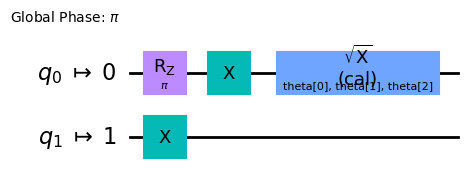

In [192]:
add_parametrized_circuit(qc=transpiled_circ, tgt_register=target['register'])
transpiled_circ.draw('mpl')

In [193]:
default_params, instructions, pulses  = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

Visualization of the SX Pulse (it's a Derivative Removal by Adiabatic Gate (DRAG) pulse)

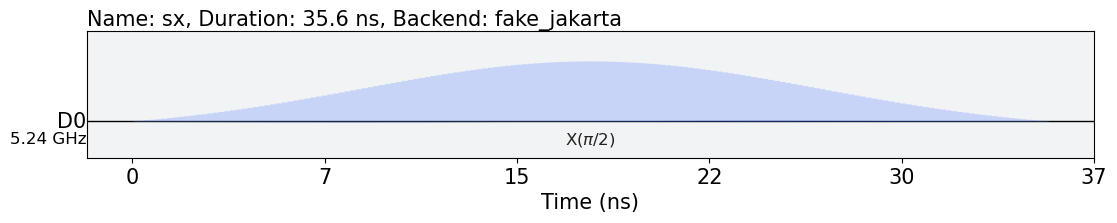

In [194]:
instructions.draw(backend=fake_backend, style=IQXStandard())

Visualization of the pulse sequence for the parameterized gate within the full circuit context

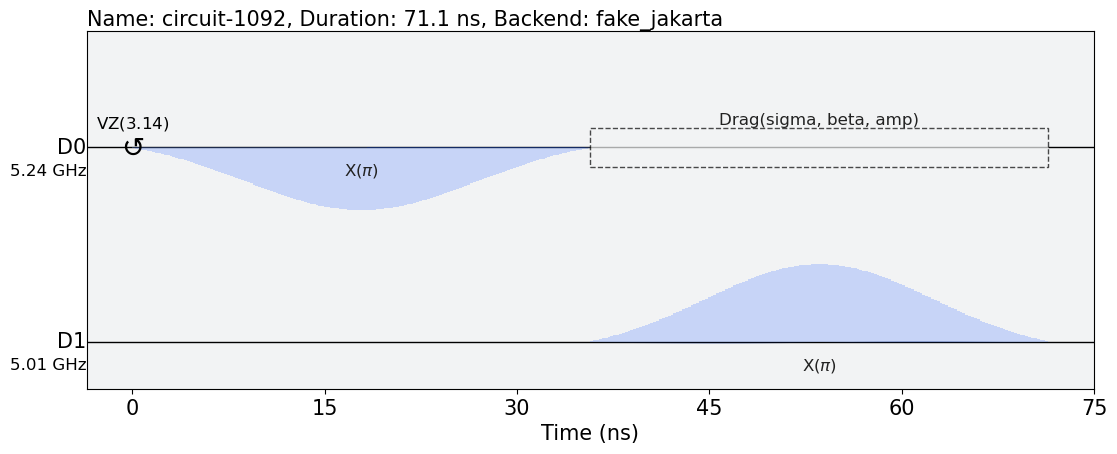

In [195]:
sched02 = schedule(transpiled_circ, fake_backend)
sched02.draw(backend=fake_backend, style=IQXStandard())

#### Plug it into ``QuantumEnvironment``

In [196]:
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = 'pulse'

In [197]:
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
dt = fake_backend.configuration().dt

dynamics_options = {'seed_simulator': None, #"configuration": fake_backend.configuration(),
                    'control_channel_map': control_channel_map, 
                    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax":dt}
                    }
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=physical_qubits,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None
)
calibration_files=None

In [198]:
estimator_options = Options(resilience_level=0, optimization_level=0, 
                            execution= ExecutionOptions(shots=N_shots*sampling_Paulis))

In [199]:
dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=physical_qubits, **dynamics_options)
dynamics_backend.target.qubit_properties = qubit_properties

In [200]:
# Wrap all info in one QiskitConfig
# Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend)
Qiskit_setup = QiskitConfig(parametrized_circuit=add_parametrized_circuit, backend=dynamics_backend,
                            estimator_options=estimator_options, channel_freq=channel_freq,
                            solver=solver)
Qiskit_setup

QiskitConfig(parametrized_circuit=<function add_parametrized_circuit at 0x2e1bbe700>, backend=<qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x2e7adba90>, estimator_options=Options(optimization_level=0, resilience_level=0, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier=None, noise_factors=None, extrapolator=None), execution=ExecutionOptions(shots=10000, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)), solver=<qiskit_dynamics.solvers.solver_classes.Solver object at 0x2e7a6f790>, channel_freq={'d0': 5236351487.460436, 'u0': (5014160311.321986+0j)}, do_calibrations=True, calibration_files=None)

In [201]:
physical_qubits

(0,)

In [202]:
q_env = QuantumEnvironment(target=target, abstraction_level=abstraction_level,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.5)

Starting Rabi experiment for qubit 0...


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/torch_contextual_gate_calibration'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
# Circuit context
import gym
from torch_quantum_environment import TorchQuantumEnvironment
from gym.spaces import Box, Space

seed = 10
training_steps_per_gate = 2000
benchmark_cycle = 100
# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 2  # Number of times target Instruction is applied in Circuit
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 4 # Choose how many control parameters in pulse/circuit parametrization
min_bound_actions =  - 0.1
max_bound_actions =  0.1
scale_factor = 0.1
observation_space = Box(low=np.array([0, 0]), high=np.array([1, tgt_instruction_counts]), shape=(2,),
                        seed=seed)
action_space = Box(low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed)

torch_env = TorchQuantumEnvironment(q_env, target_circuit, action_space,
                                    observation_space, batch_size=batchsize,
                                    training_steps_per_gate=training_steps_per_gate,
                                    benchmark_cycle = benchmark_cycle,
                                    intermediate_rewards=False,
                                    seed=None,)


ModuleNotFoundError: No module named 'gym'

#### Plug it into ``TorchQuantumEnvironment``